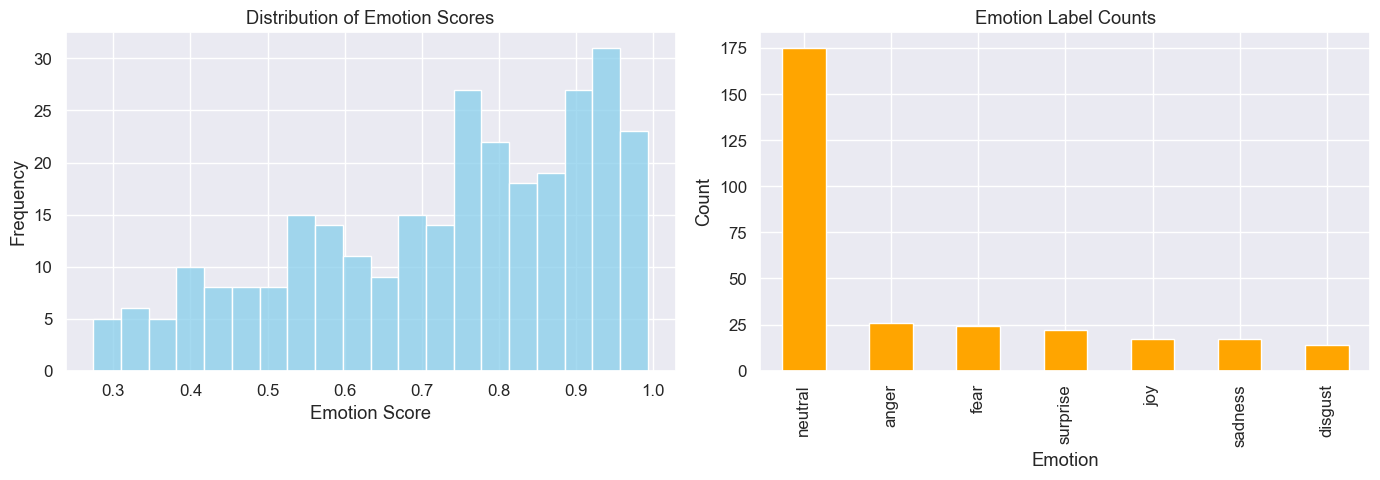

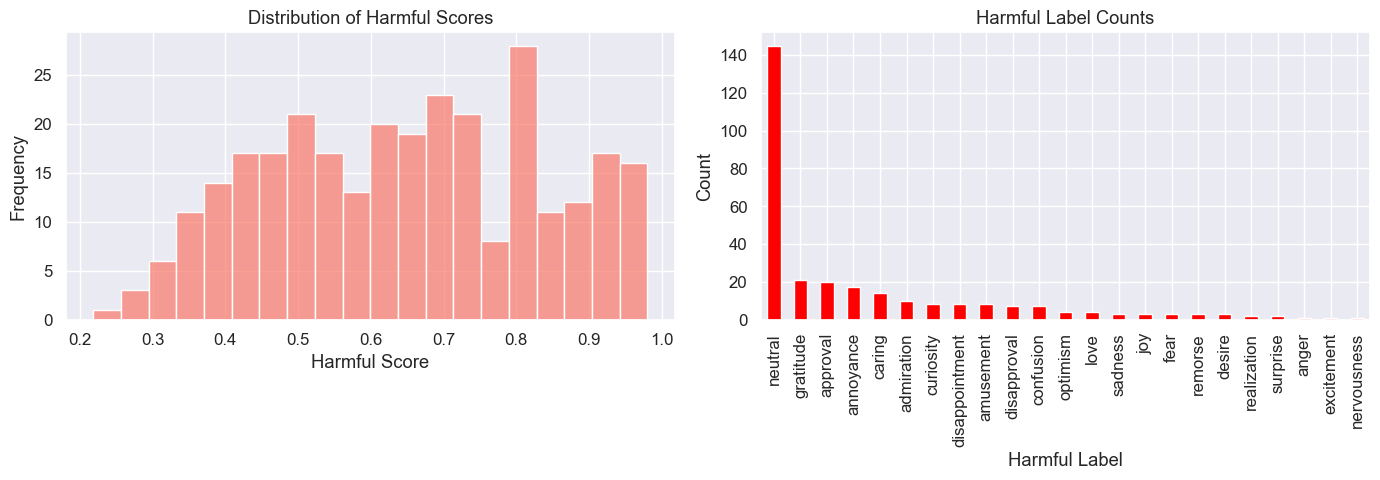

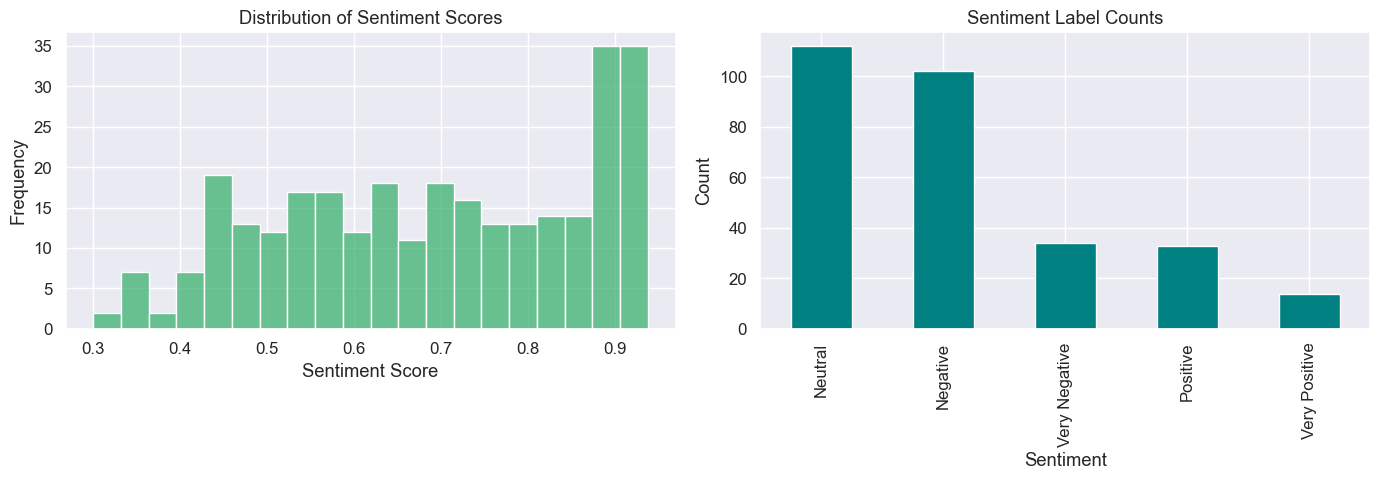

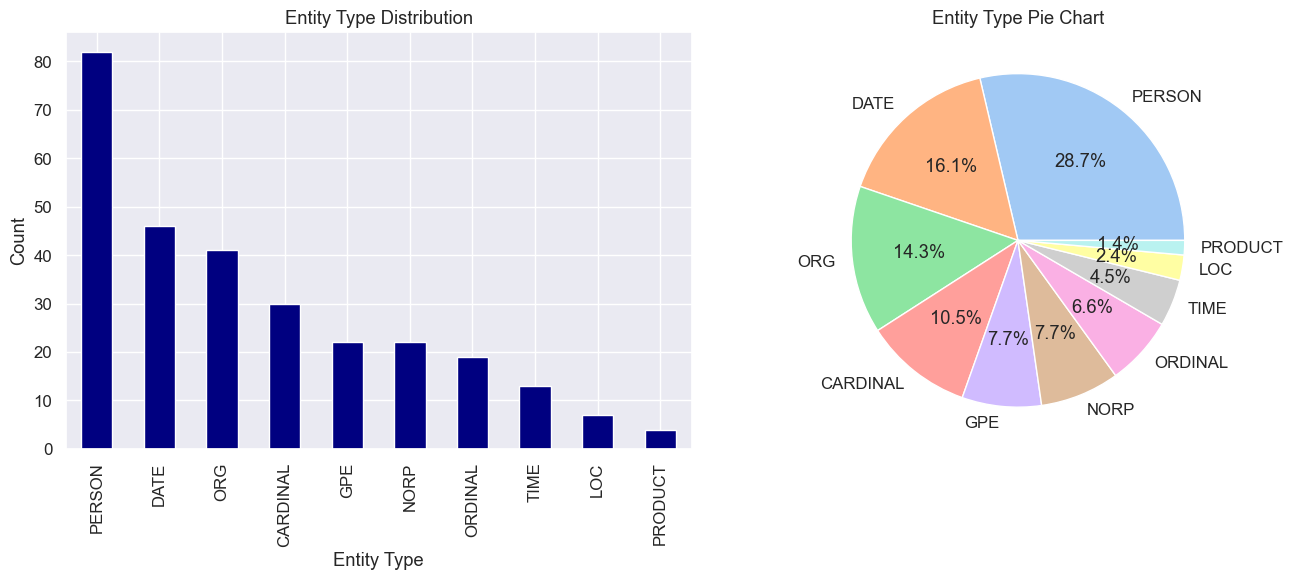

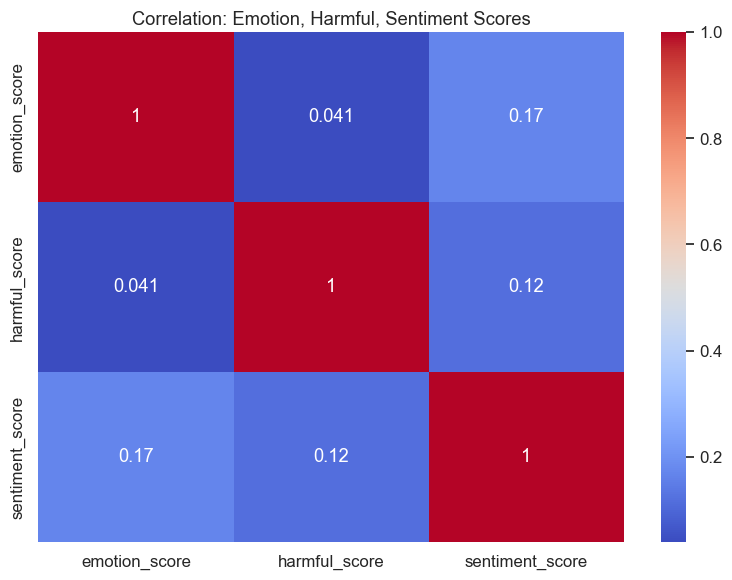

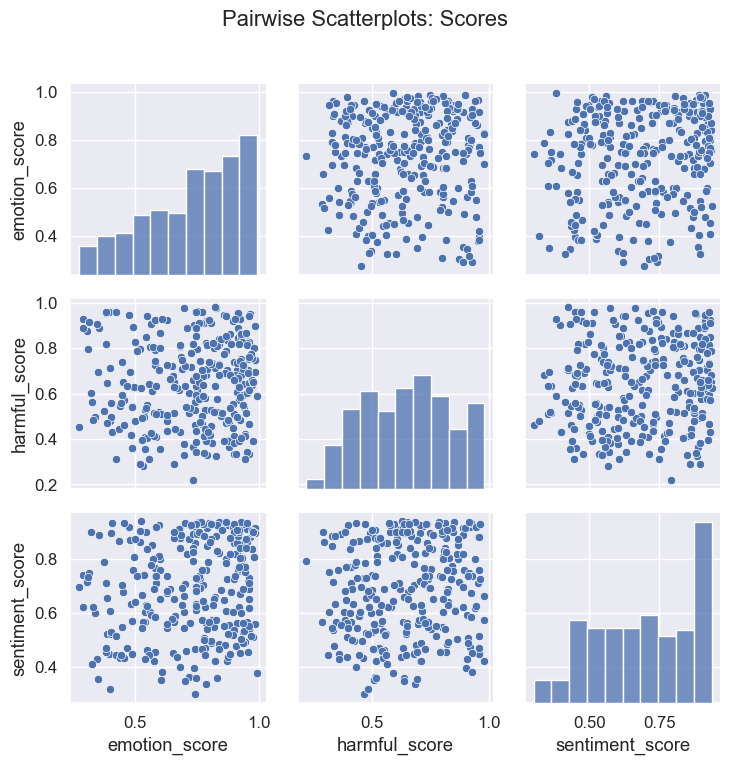

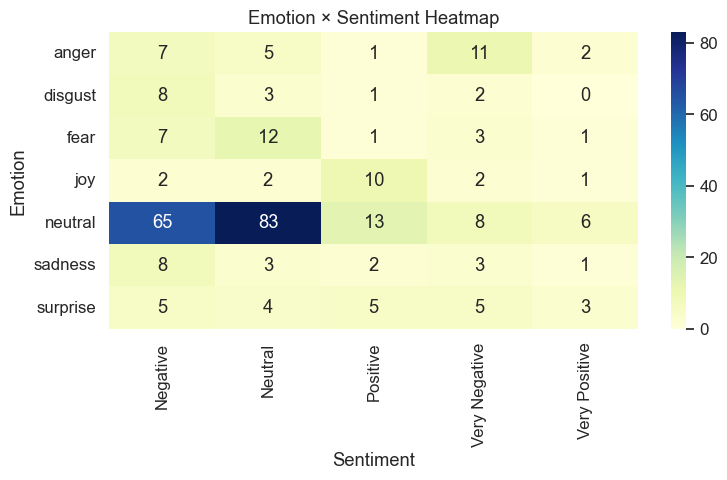

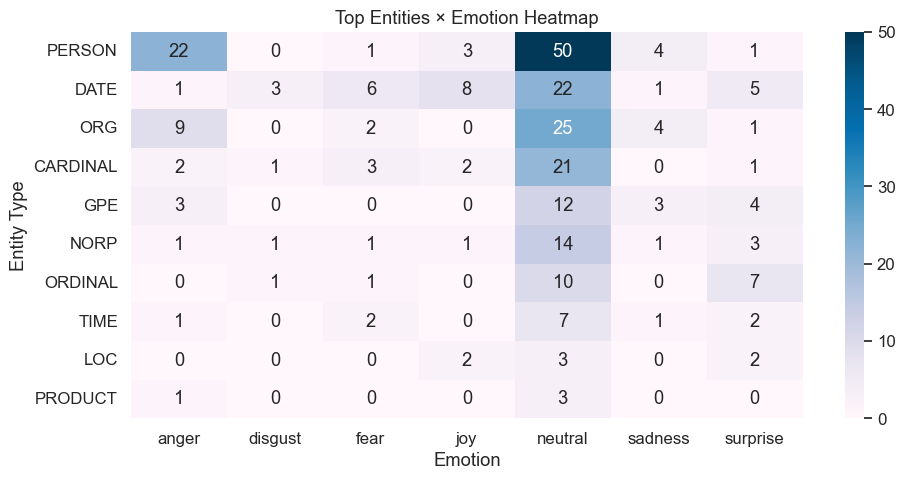

C:\Users\Adarsh Ranjan\AppData\Local\Temp\ipykernel_15056\1155333695.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=sentiment_df['sentiment'], y=harmful_df['score'], palette="Set2")


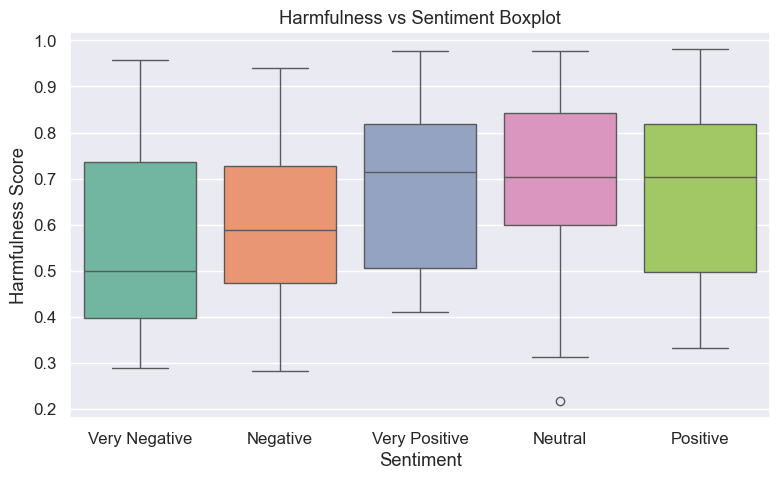


=== Outlier Detection Table (Top 10) ===
Empty DataFrame
Columns: [Outlier Type, Comment]
Index: []

=== Emotion-Sentiment Summary ===
                       harmful_score            
                                mean   std count
emotion  sentiment                              
anger    Negative               0.61  0.21     7
         Neutral                0.59  0.14     5
         Positive               0.58   NaN     1
         Very Negative          0.54  0.14    11
         Very Positive          0.58  0.23     2
disgust  Negative               0.51  0.12     8
         Neutral                0.70  0.18     3
         Positive               0.63   NaN     1
         Very Negative          0.75  0.19     2
fear     Negative               0.67  0.21     7
         Neutral                0.62  0.08    12
         Positive               0.89   NaN     1
         Very Negative          0.66  0.23     3
         Very Positive          0.50   NaN     1
joy      Negative              

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ======================
# Load CSV Files
# ======================
emotion_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\emotion_results.csv')
entities_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\entities.csv')
harmful_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\harmful_flags.csv')
sentiment_df = pd.read_csv(r'E:\Coding\BDA-PySpark\realtime-pipeline\results\sentiment_results.csv')

plt.style.use('ggplot')
sns.set(font_scale=1.1)

# ================================================================
# 1. Emotion: Distribution & Label Counts
# ================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(emotion_df['score'], bins=20, color='skyblue', ax=axes[0])
axes[0].set(title='Distribution of Emotion Scores', xlabel='Emotion Score', ylabel='Frequency')
emotion_df['emotion'].value_counts().plot(kind='bar', color='orange', ax=axes[1])
axes[1].set(title='Emotion Label Counts', xlabel='Emotion', ylabel='Count')
plt.tight_layout()
plt.show()

# ================================================================
# 2. Harmful: Distribution & Label Counts
# ================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(harmful_df['score'], bins=20, color='salmon', ax=axes[0])
axes[0].set(title='Distribution of Harmful Scores', xlabel='Harmful Score', ylabel='Frequency')
harmful_df['harmful_label'].value_counts().plot(kind='bar', color='red', ax=axes[1])
axes[1].set(title='Harmful Label Counts', xlabel='Harmful Label', ylabel='Count')
plt.tight_layout()
plt.show()

# ================================================================
# 3. Sentiment: Distribution & Label Counts
# ================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(sentiment_df['score'], bins=20, color='mediumseagreen', ax=axes[0])
axes[0].set(title='Distribution of Sentiment Scores', xlabel='Sentiment Score', ylabel='Frequency')
sentiment_df['sentiment'].value_counts().plot(kind='bar', color='teal', ax=axes[1])
axes[1].set(title='Sentiment Label Counts', xlabel='Sentiment', ylabel='Count')
plt.tight_layout()
plt.show()

# ================================================================
# 4. Entity Type Distribution: Bar + Pie
# ================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
entity_types = []
for ent_str in entities_df['entities'].dropna():
    entity_types += re.findall(r':(\w+)', ent_str)
et_counts = pd.Series(entity_types).value_counts()
et_counts.plot(kind='bar', color='navy', ax=axes[0])
axes[0].set(title='Entity Type Distribution', xlabel='Entity Type', ylabel='Count')
et_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'), ylabel='', ax=axes[1])
axes[1].set(title='Entity Type Pie Chart')
plt.tight_layout()
plt.show()

# ================================================================
# 5. Correlation Heatmap: Emotion, Harmful, Sentiment Scores
# ================================================================
joined = emotion_df[['score']].rename(columns={'score': 'emotion_score'})
joined['harmful_score'] = harmful_df['score']
joined['sentiment_score'] = sentiment_df['score']
plt.figure(figsize=(8, 6))
sns.heatmap(joined.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation: Emotion, Harmful, Sentiment Scores')
plt.tight_layout()
plt.show()

# ================================================================
# 6. Pairplot of Scores
# ================================================================
sns.pairplot(joined)
plt.suptitle('Pairwise Scatterplots: Scores', y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# 7. Emotion × Sentiment Heatmap
# ================================================================
plt.figure(figsize=(8, 5))
emo_sent = pd.crosstab(emotion_df['emotion'], sentiment_df['sentiment'])
sns.heatmap(emo_sent, annot=True, cmap='YlGnBu', fmt='d')
plt.title("Emotion × Sentiment Heatmap")
plt.xlabel("Sentiment")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()

# ================================================================
# 8. Entity vs Emotion Heatmap (Top 10 Entities)
# ================================================================
entity_emotion_map = []
for i, row in entities_df.iterrows():
    if isinstance(row['entities'], str):
        ents = re.findall(r'(\w+):(\w+)', row['entities'])
        for ent_text, ent_type in ents:
            entity_emotion_map.append((ent_type, emotion_df.loc[i, 'emotion']))
entity_emotion_df = pd.DataFrame(entity_emotion_map, columns=['EntityType', 'Emotion'])
top_entities = entity_emotion_df['EntityType'].value_counts().nlargest(10).index
pivot = pd.crosstab(entity_emotion_df['EntityType'], entity_emotion_df['Emotion'])
plt.figure(figsize=(10, 5))
sns.heatmap(pivot.loc[top_entities], annot=True, cmap="PuBu", fmt='d')
plt.title("Top Entities × Emotion Heatmap")
plt.xlabel("Emotion")
plt.ylabel("Entity Type")
plt.tight_layout()
plt.show()

# ================================================================
# 9. Harmfulness vs Sentiment Boxplot
# ================================================================
plt.figure(figsize=(8, 5))
sns.boxplot(x=sentiment_df['sentiment'], y=harmful_df['score'], palette="Set2")
plt.title("Harmfulness vs Sentiment Boxplot")
plt.xlabel("Sentiment")
plt.ylabel("Harmfulness Score")
plt.tight_layout()
plt.show()

# ================================================================
# 10. Outlier Detection Table (Sarcastic / Toxic-Positive)
# ================================================================
combined = pd.DataFrame({
    'comment_id': emotion_df['comment_id'] if 'comment_id' in emotion_df.columns else range(len(emotion_df)),
    'emotion': emotion_df['emotion'],
    'sentiment': sentiment_df['sentiment'],
    'harmful_score': harmful_df['score'],
    'comment_text': sentiment_df['text'] if 'text' in sentiment_df.columns else None
})

def detect_outliers(data):
    outliers = []
    for _, row in data.iterrows():
        if row['sentiment'] == 'positive' and row['harmful_score'] > 0.6:
            outliers.append(('Sarcastic/Toxic-Positive', row['comment_text']))
        elif row['sentiment'] == 'negative' and row['harmful_score'] < 0.4:
            outliers.append(('False Negative / Mildly Negative', row['comment_text']))
    return pd.DataFrame(outliers, columns=['Outlier Type', 'Comment'])

outlier_table = detect_outliers(combined)
print("\n=== Outlier Detection Table (Top 10) ===")
print(outlier_table.head(10))

# ================================================================
# 11. Emotion-Sentiment Summary Table
# ================================================================
summary = combined.groupby(['emotion', 'sentiment']).agg({
    'harmful_score': ['mean', 'std', 'count']
}).round(2)
print("\n=== Emotion-Sentiment Summary ===")
print(summary)
